# Setup

In [49]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from collections import Counter
from dice_ml import Model, Dice, Data
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn import metrics
from sklearn.metrics import make_scorer
from tqdm import trange, tqdm

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Data Description
The original dataset, sourced from Kaggle, consisted of 123 features and 8,378 rows. These features described the demographics of the pair (eg. age, race, field of study/work), their expectations from the speed dating event (eg. expected number of matches), and their interests or hobbies (eg. sports, museum, art). A preview can be found in `Table 1`.

It also contained the pair’s rating for themselves and their partners on each of the listed traits (attractiveness, being funny, intelligence, sincerity, shared interests, and ambition), their preference and level of importance  for each trait, and derived features from the trait ratings.


In [51]:
df = pd.read_csv('speeddating.csv')
df[['gender', 'match',
    'samerace']] = pd.get_dummies(df[['gender', 'match', 'samerace']],
                                  drop_first=True)
df.drop(['has_null', 'wave'], axis=1, inplace=True)
display(df.head())
display(HTML('<center><i>Table 1. Preview of the Dataset</i></center>'))

,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,attractive,sincere,intelligence,funny,ambition,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,d_attractive_partner,d_sincere_partner,d_intelligence_partner,d_funny_partner,d_ambition_partner,d_shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0,21.0000,27.0000,6.0000,b'[4-6]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',0,2.0000,4.0000,b'[2-5]',b'[2-5]',b'Law',35.0000,20.0000,20.0000,20.0000,0.0000,5.0000,b'[21-100]',b'[16-20]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',6.0000,8.0000,8.0000,8.0000,8.0000,6.0000,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',15.0000,20.0000,20.0000,15.0000,15.0000,15.0000,b'[0-15]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',b'[0-15]',6.0000,8.0000,8.0000,8.0000,7.0000,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',6.0000,9.0000,7.0000,7.0000,6.0000,5.0000,b'[6-8]',b'[9-10]',b'[6-8]',b'[6-8]',b'[6-8]',b'[0-5]',9.0000,2.0000,8.0000,9.0000,1.0000,1.0000,5.0000,1.0000,5.0000,6.0000,9.0000,1.0000,10.0000,10.0000,9.0000,8.0000,1.0000,b'[9-10]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[9-10]',b'[9-10]',b'[9-10]',b'[6-8]',b'[0-5]',0.1400,b'[0-0.33]',3.0000,2.0000,4.0000,b'[0-4]',b'[0-3]',b'[3-5]',7.0000,6.0000,b'[6-8]',b'[5-6]',0.0000,b'1',b'0',0
1,0,21.0000,22.0000,1.0000,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'European/Caucasian-American',0,2.0000,4.0000,b'[2-5]',b'[2-5]',b'Law',60.0000,0.0000,0.0000,40.0000,0.0000,0.0000,b'[21-100]',b'[0-15]',b'[0-15]',b'[21-100]',b'[0-15]',b'[0-15]',7.0000,8.0000,10.0000,7.0000,7.0000,5.0000,b'[6-8]',b'[6-8]',b'[9-10]',b'[6-8]',b'[6-8]',b'[0-5]',15.0000,20.0000,20.0000,15.0000,15.0000,15.0000,b'[0-15]',b'[16-20]',b'[16-20]',b'[0-15]',b'[0-15]',b'[0-15]',6.0000,8.0000,8.0000,8.0000,7.0000,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',7.0000,8.0000,7.0000,8.0000,5.0000,6.0000,b'[6-8]',b'[6-8]',b'[6-8]',b'[6-8]',b'[0-5]',b'[6-8]',9.0000,2.0000,8.0000,9.0000,1.0000,1.0000,5.0000,1.0000,5.0000,6.0000,9.0000,1.0000,10.0000,10.0000,9.0000,8.0000,1.0000,b'[9-10]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[0-5]',b'[6-8]',b'[9-10]',b'[0-5]',b'[9-10]',b'[9-10]',b'[9-10]',b'[6-8]',b'[0-5]',0.5400,b'[0.33-1]',3.0000,2.0000,4.0000,b'[0-4]',b'[0-3]',b'[3-5]',7.0000,5.0000,b'[6-8]',b'[5-6]',1.0000,b'1',b'0',0
2,0,21.0000,22.0000,1.0000,b'[0-1]',b'Asian/Pacific Islander/Asian-American',b'Asian/Pacific Islander/Asian-American',1,2.0000,4.0000,b'[2-5]',b'[2-5]',b'Law',19.0000,18.0000,19.0000,18.0000,14.0000,12.0000,

# Data Exploration

## Match
As depicted in `Figure 1`, out of the 8,378 pairs of participants analyzed, 1,380 pairs (16.47%) resulted in a match, while the remaining 6,998 pairs (83.53%) did not.


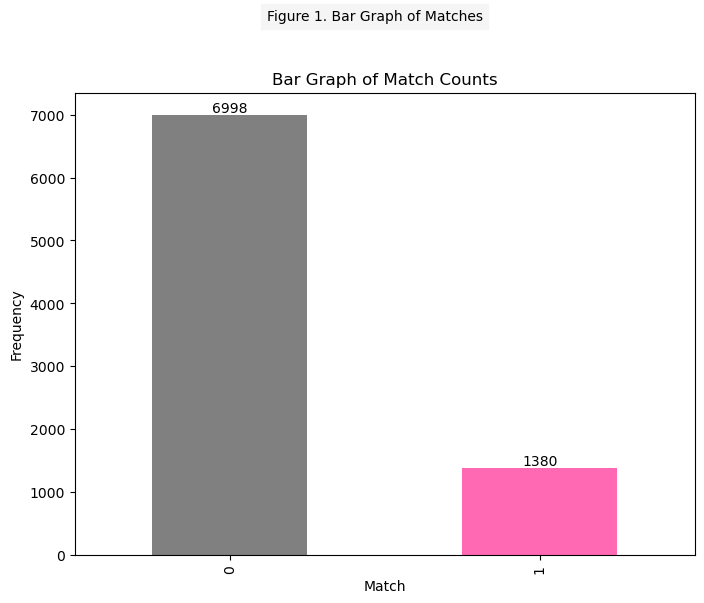

In [4]:
# Get value counts of the 'match' column
value_counts = df['match'].value_counts()

colors = ['grey' if value == 0 else 'hotpink' for value in value_counts.index]

# Plotting a bar graph
plt.figure(figsize=(8, 6))
ax = value_counts.plot(kind='bar', color=colors)
plt.xlabel('Match')
plt.ylabel('Frequency')
plt.title('Bar Graph of Match Counts')

# Annotate each bar with its count value
for i, count in enumerate(value_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')

# Add figure text
plt.figtext(0.5,
            1.001,
            'Figure 1. Bar Graph of Matches',
            ha='center',
            fontsize=10,
            backgroundcolor='whitesmoke')

plt.show()

## Demographics

`Figure 2` shows an overview of the demographics of the participants. The gender distribution among participants was evenly balanced (4184 male, 4194 female). Regarding racial similarity, 3,316 pairs shared the same race, while 5,062 pairs did not. Participants primarily consisted of young adults, with ages from 18 to 55, with a mean age of 26. The pairs showed a mean age gap of 3 years.

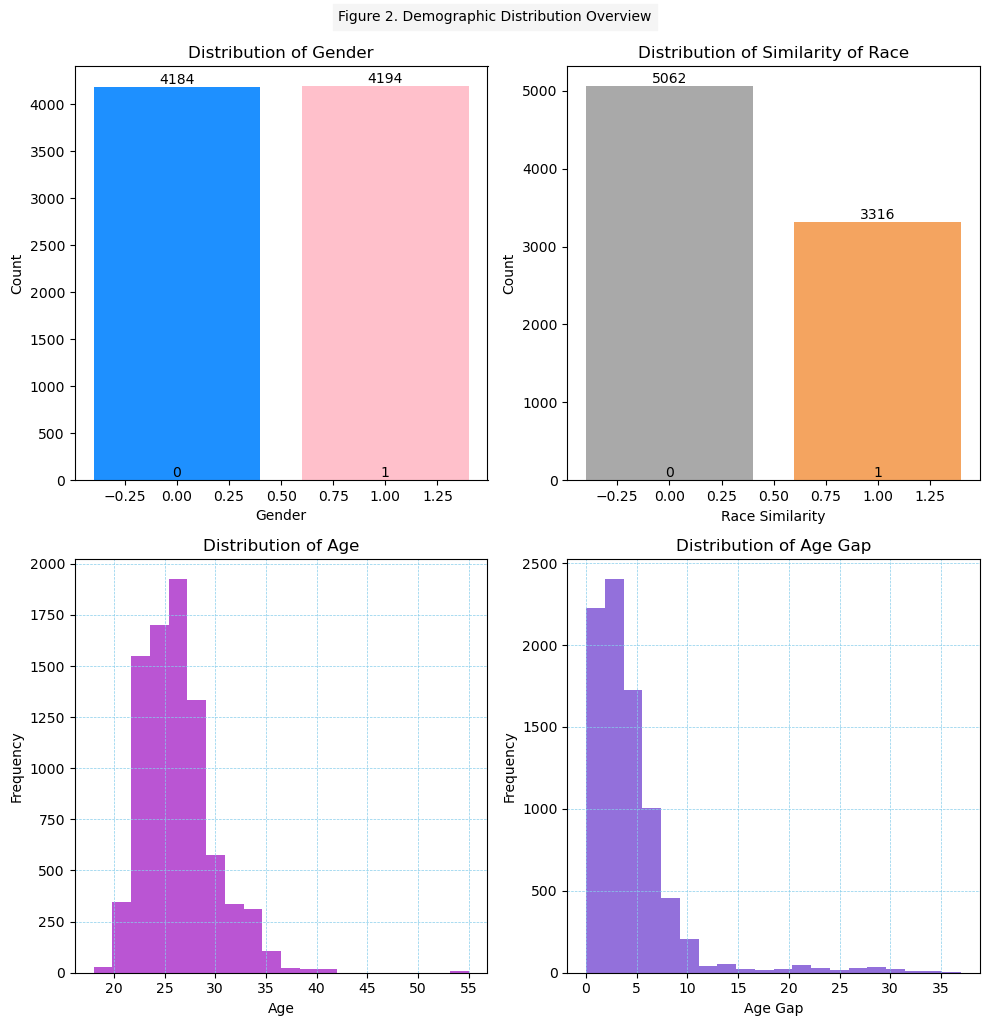

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Assuming df['gender'] contains categorical data (e.g., 'male', 'female')
gender_counts = df['gender'].value_counts()

# Assigning colors based on gender categories
colors_gender = ['pink', 'dodgerblue']

# Creating the first subplot for gender distribution
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, first subplot
bars_gender = plt.bar(gender_counts.index,
                      gender_counts.values,
                      color=colors_gender)

# Adding labels on top of each bar for gender distribution
for bar, label in zip(bars_gender, gender_counts.index):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             str(int(bar.get_height())),
             ha='center',
             va='bottom')
    plt.text(bar.get_x() + bar.get_width() / 2,
             0,
             label,
             ha='center',
             va='bottom',
             color='black')

# Adding labels and title for gender distribution
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Gender')

# Assuming df['samerace'] contains categorical data
samerace_counts = df['samerace'].value_counts()

# Assigning colors based on race similarity categories
colors_samerace = ['darkgrey', 'sandybrown']

# Creating the second subplot for race similarity distribution
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, second subplot
bars_samerace = plt.bar(samerace_counts.index,
                        samerace_counts.values,
                        color=colors_samerace)

# Adding labels on top of each bar for race similarity distribution
for bar, label in zip(bars_samerace, samerace_counts.index):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             str(int(bar.get_height())),
             ha='center',
             va='bottom')
    plt.text(bar.get_x() + bar.get_width() / 2,
             0,
             label,
             ha='center',
             va='bottom',
             color='black')

# Adding labels and title for race similarity distribution
plt.xlabel('Race Similarity')
plt.ylabel('Count')
plt.title('Distribution of Similarity of Race')

# Plotting histograms of 'age' and 'd_age' in the third and fourth subplots
df_exp_hist = df[['age', 'd_age']]

plt.subplot(2, 2, 3)  # 2 rows, 2 columns, third subplot
df_exp_hist['age'].hist(bins=20, color='mediumorchid', grid=True)
plt.grid(color='skyblue', linestyle='--', linewidth=0.5)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')

plt.subplot(2, 2, 4)  # 2 rows, 2 columns, fourth subplot
df_exp_hist['d_age'].hist(bins=20, color='mediumpurple', grid=True)
plt.grid(color='skyblue', linestyle='--', linewidth=0.5)
plt.xlabel('Age Gap')
plt.ylabel('Frequency')
plt.title('Distribution of Age Gap')

# Add figure text
plt.figtext(0.5,
            1.01,
            'Figure 2. Demographic Distribution Overview',
            ha='center',
            backgroundcolor='whitesmoke')

# Adjust layout
plt.tight_layout()

# Displaying the subplots
plt.show()

There is a lack of consistency in field labeling, where variations such as "Business," "MBA," "Business[MBA]," and "business" are treated as distinct fields, as shown in `Figure 3`. Subsequently, a cleaning process was implemented to eliminate duplicates, and similar fields were consolidated.

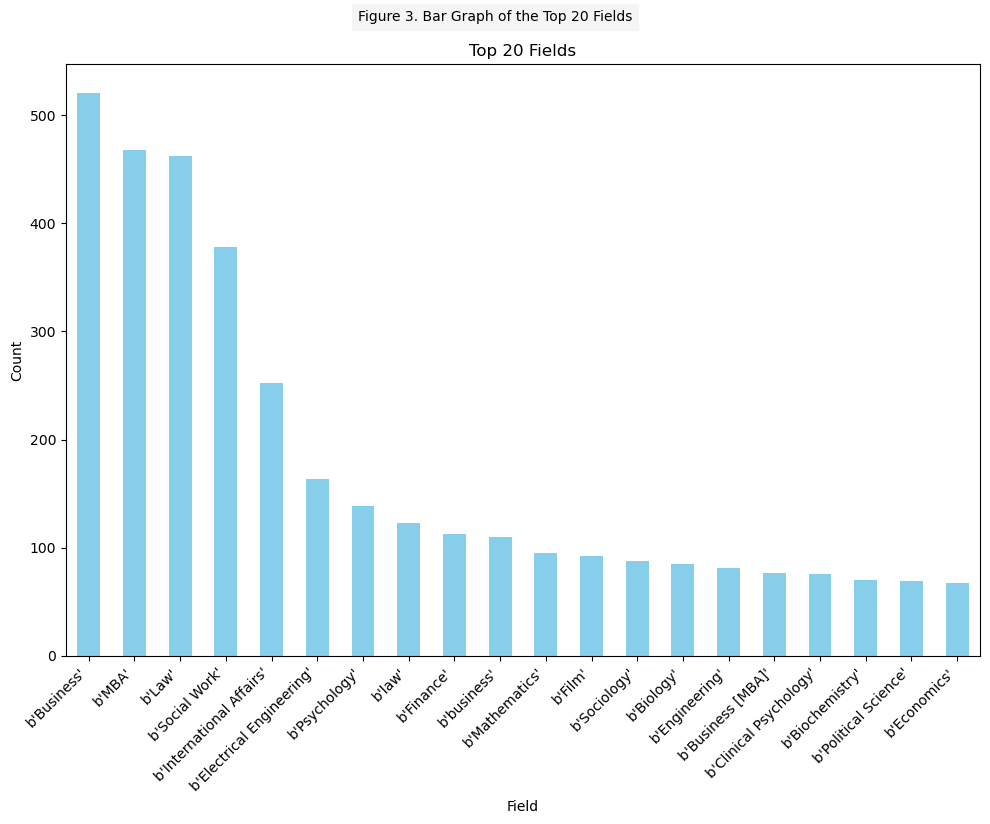

In [6]:
# Get the top 20 most common fields
top_fields = df['field'].value_counts().head(20)

# Plotting the bar graph
plt.figure(figsize=(10, 8))
top_fields.plot(kind='bar', color='skyblue')
plt.xlabel('Field')
plt.ylabel('Count')
plt.title('Top 20 Fields')
# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add figure text
plt.figtext(0.5,
            1.01,
            'Figure 3. Bar Graph of the Top 20 Fields',
            ha='center',
            backgroundcolor='whitesmoke')

plt.tight_layout()
plt.show()

## Traits

Due to the extensive array of features within the dataset, particularly concerning personality traits (e.g., attractiveness, intelligence, humor, shared interests, ambition, and sincerity), individual correlation maps were generated for each trait. The correlation map for the Attractive trait is found in `Figure 4`.

Furthermore, it was observed that the preference rating for each trait exhibited a substantial correlation with a corresponding bin of their derived feature (e.g., pref_o_attractive displayed a high correlation with d_pref_o_attractive_b'[16-100]').

As the primary focus of the study centered on the base ratings of the pairs (e.g., attractive_o, attractive_partner), both the preference and importance ratings of the traits were excluded from the final dataset.


In [7]:
df_exp = pd.read_csv('speeddating.csv')

cols_no_field = df_exp.drop(['field', 'wave'], axis=1)
df_exp = pd.get_dummies(cols_no_field, drop_first=True)

# Clean the trait column names
df_exp.rename(columns={
    'ambitous_o': 'ambition_o',
    'd_ambitous_o': 'd_ambition_o',
    'd_ambtition_important': 'd_ambition_important',
    'ambtition_important': 'ambition_important',
    'pref_o_ambitious': 'pref_o_ambition',
    'intellicence_important': 'intelligence_important',
    'sinsere_o': 'sincere_o'
},
              inplace=True)

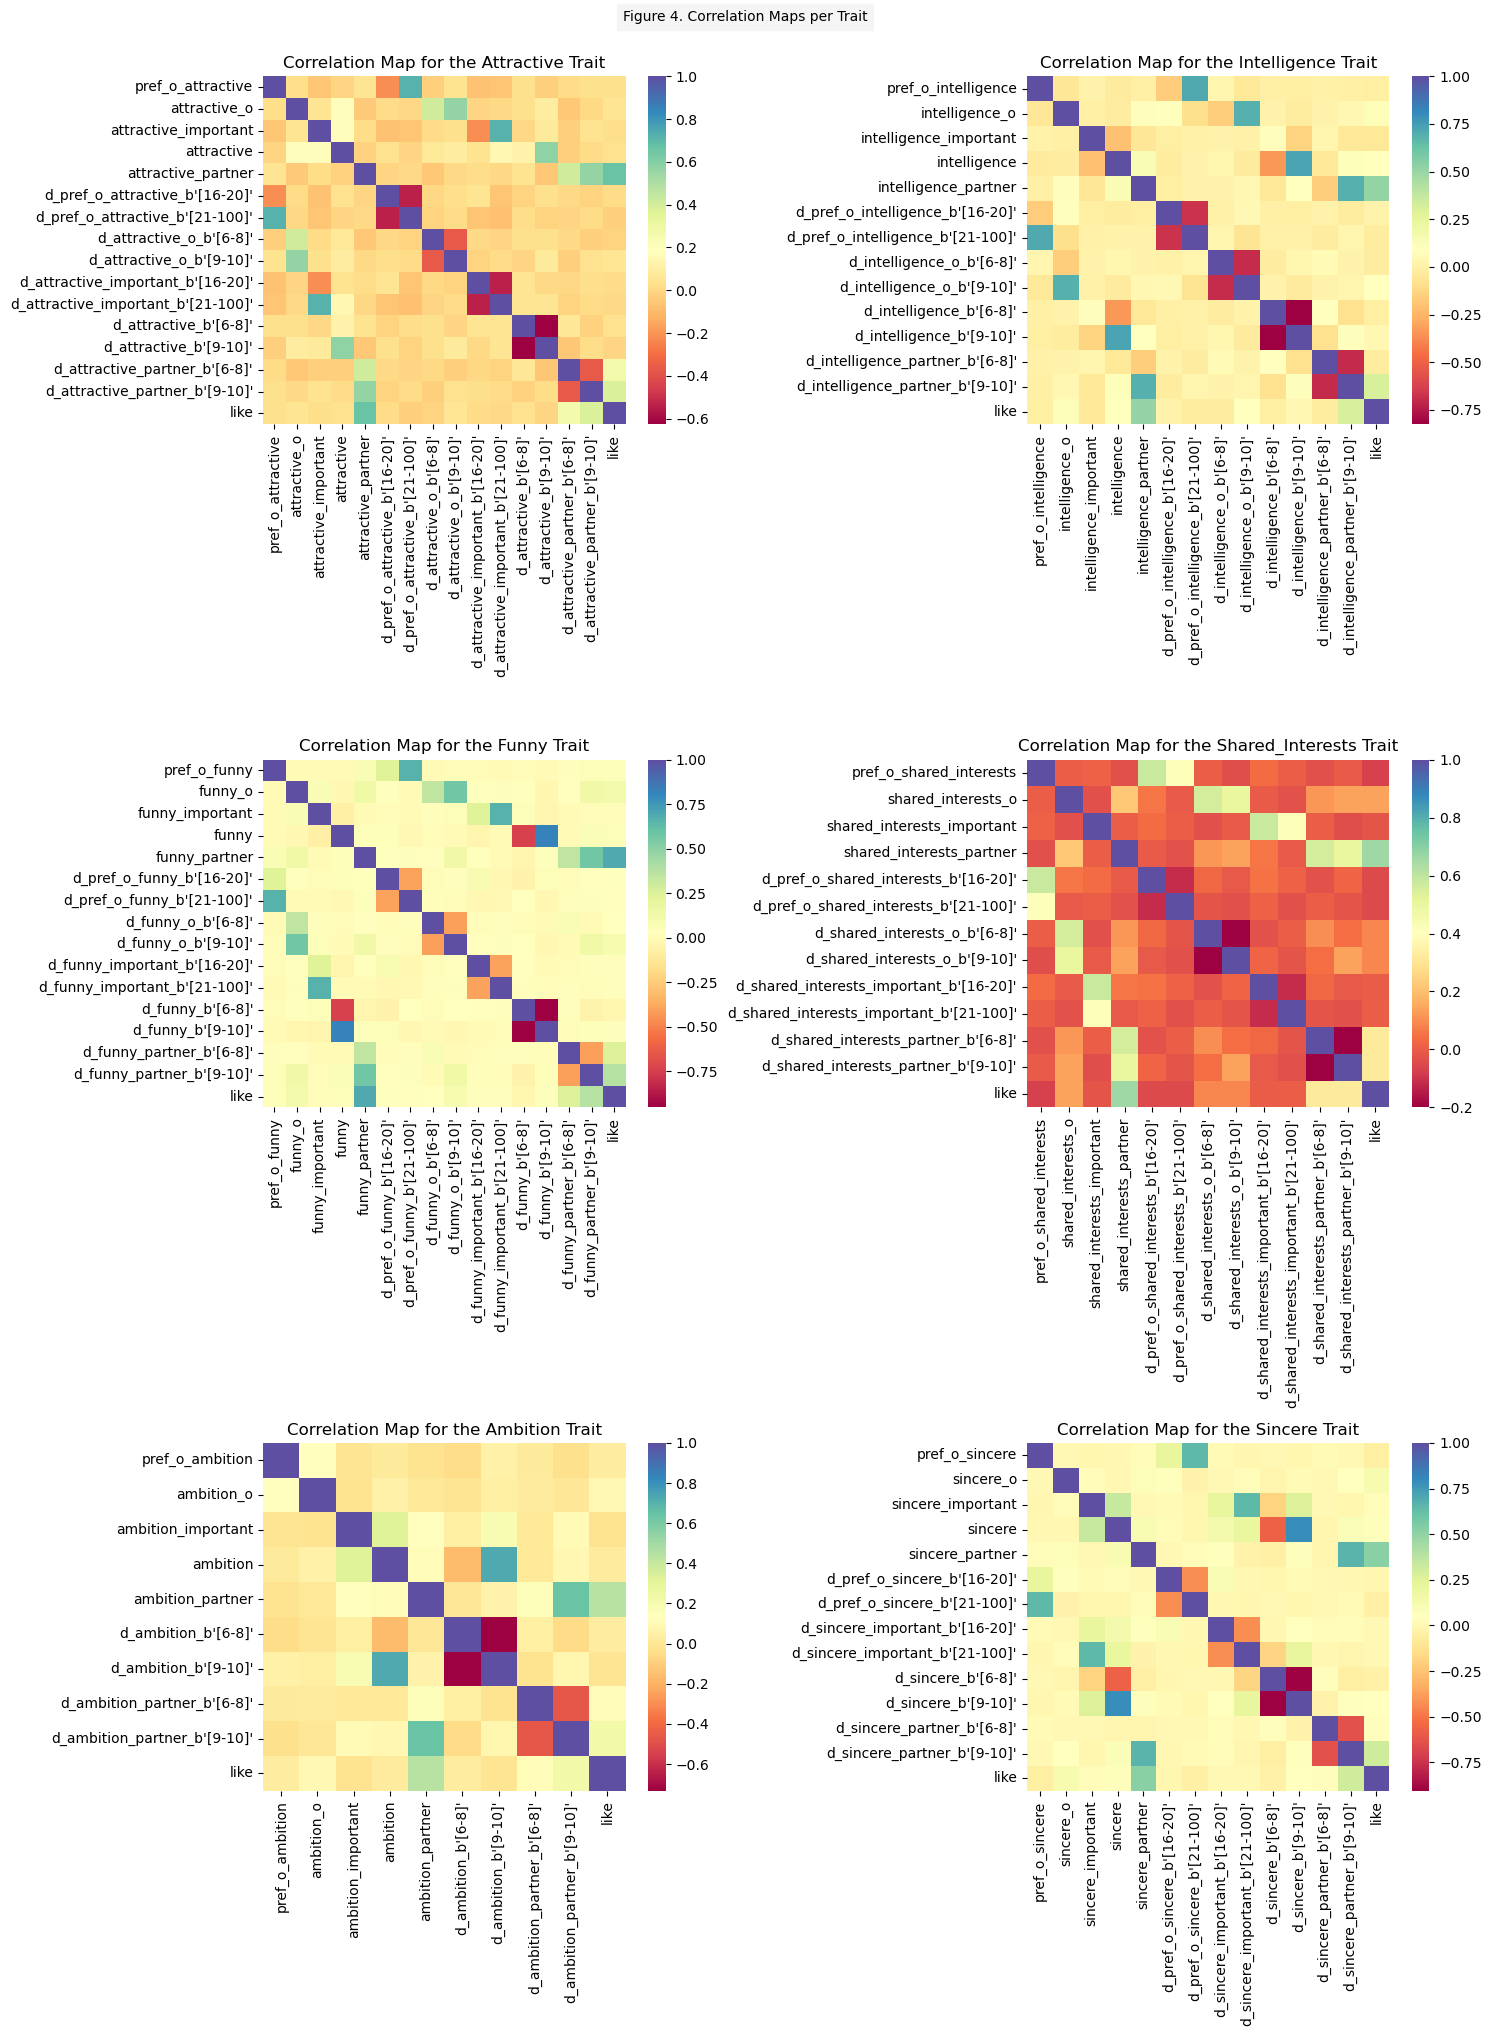

In [8]:
def corr_map(trait, df):
    trait_columns = [col for col in df.columns if trait in col]
    trait_columns.append('like')
    df_filtered = df[trait_columns]
    correlation_matrix = df_filtered.corr()
    return correlation_matrix


traits = [
    'attractive', 'intelligence', 'funny', 'shared_interests', 'ambition',
    'sincere'
]

fig, axes = plt.subplots(3, 2, figsize=(15, 20))
axes = axes.flatten()

for i, trait in enumerate(traits):
    ax = axes[i]
    correlation_matrix = corr_map(trait, df_exp)
    sns.heatmap(correlation_matrix, cmap='Spectral', fmt=".2f", ax=ax)
    ax.set_title(f'Correlation Map for the {trait.title()} Trait')

# Remove any remaining empty subplots
for ax in axes[len(traits):]:
    ax.remove()

# Add figure text
plt.figtext(0.5,
            1.01,
            'Figure 4. Correlation Maps per Trait',
            ha='center',
            backgroundcolor='whitesmoke')

plt.tight_layout()
plt.show()

Twenty-eight features were chosen to account for the pair's base ratings of the traits, their demographics, and expectations of the event. `Figure 5` shows the correlation map of these features to each other. From the given map, we see that Like is highly correlated to the person's rating of attractiveness, humor, and shared interests (attractive_partner, funny_partner, and shared_interests_partner).

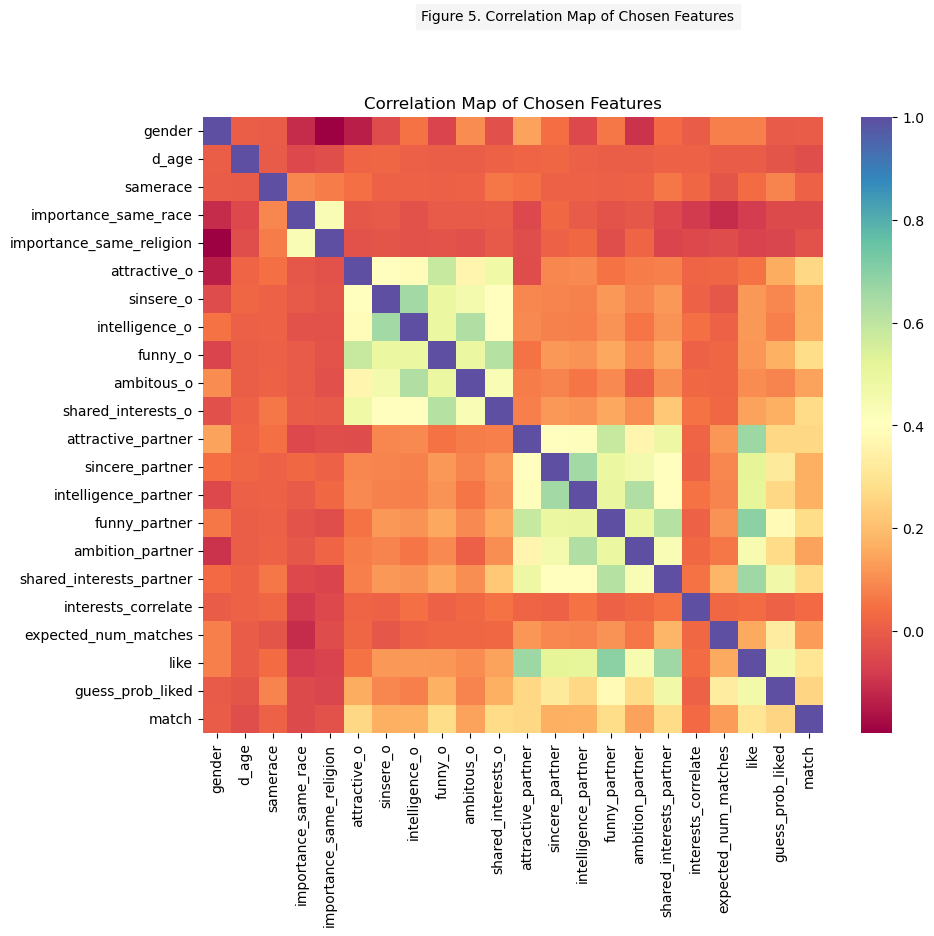

In [9]:
columns = [
    'gender', 'd_age', 'samerace', 'importance_same_race',
    'importance_same_religion', 'attractive_o', 'sinsere_o', 'intelligence_o',
    'funny_o', 'ambitous_o', 'shared_interests_o', 'attractive_partner',
    'sincere_partner', 'intelligence_partner', 'funny_partner',
    'ambition_partner', 'shared_interests_partner', 'interests_correlate',
    'expected_num_matches', 'like', 'guess_prob_liked', 'match'
]

df_feat = pd.get_dummies(df[columns], drop_first=True)

# Create the correlation map with colors
plt.figure(figsize=(10, 8))
sns.heatmap(df_feat.corr(), cmap='Spectral', fmt=".2f")
plt.title('Correlation Map of Chosen Features')

# Add figure text
plt.figtext(0.5,
            1.001,
            'Figure 5. Correlation Map of Chosen Features',
            ha='center',
            backgroundcolor='whitesmoke')

plt.show()

# Baseline

## Proportional Chance Criterion (PCC)
The Proportional Chance Criterion (PCC) was calculated to establish a baseline against which the performance of the model could be evaluated. This criterion provides an indication of the expected accuracy if predictions were made at random, considering the distribution of the target variable within the dataset.

The PCC yielded a result of 72.48%. Multiplying this value by 1.25 yields 90.60%, indicating that the model's accuracy should surpass 90.60% to perform better than chance.


In [10]:
state_counts = Counter(df.match)
df_state = pd.DataFrame.from_dict(state_counts, orient='index')

num = (df_state[0] / df_state[0].sum())**2
pcc = num.sum()
print(f'     pcc = {pcc:.4f}')
print(f'1.25*pcc = {pcc*1.25:.4f}')

     pcc = 0.7248
1.25*pcc = 0.9060


## Previous Study 
In a previous study by user ‘MicaelD’ from Kaggle developed a classification model that predicted the target variable "match" with an accuracy score of 84.29% and a precision score of 56.67% using a Gradient Boosting Classifier Model. These scores serve as the benchmark against which the classifier model will be compared. A preview of the MicaelD's processed dataset can be found in `Table 2`.

In [53]:
df_base = df.copy()

for col in df.columns:
    if df_base[col].dtype == "object":
        oe = OrdinalEncoder()
        oe.fit(df_base[[col]])
        df_base[col] = oe.fit_transform(df_base[[col]])

df_base.dropna(inplace=True)
display(df_base.head())
display(
    HTML("<center><i>Table 2. Preview of MicaelD's "
         "processed Dataset</i></center>"))

,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,attractive,sincere,intelligence,funny,ambition,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,d_attractive_partner,d_sincere_partner,d_intelligence_partner,d_funny_partner,d_ambition_partner,d_shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0,21.0000,27.0000,6.0000,2.0000,1.0000,3.0000,0,2.0000,4.0000,1.0000,1.0000,126.0000,35.0000,20.0000,20.0000,20.0000,0.0000,5.0000,2.0000,1.0000,1.0000,1.0000,0.0000,0.0000,6.0000,8.0000,8.0000,8.0000,8.0000,6.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,15.0000,20.0000,20.0000,15.0000,15.0000,15.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,6.0000,8.0000,8.0000,8.0000,7.0000,1.0000,1.0000,1.0000,1.0000,1.0000,6.0000,9.0000,7.0000,7.0000,6.0000,5.0000,1.0000,2.0000,1.0000,1.0000,1.0000,0.0000,9.0000,2.0000,8.0000,9.0000,1.0000,1.0000,5.0000,1.0000,5.0000,6.0000,9.0000,1.0000,10.0000,10.0000,9.0000,8.0000,1.0000,2.0000,0.0000,1.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,2.0000,0.0000,2.0000,2.0000,2.0000,1.0000,0.0000,0.1400,1.0000,3.0000,2.0000,4.0000,0.0000,0.0000,1.0000,7.0000,6.0000,1.0000,1.0000,0.0000,1.0000,0.0000,0
1,0,21.0000,22.0000,1.0000,0.0000,1.0000,3.0000,0,2.0000,4.0000,1.0000,1.0000,126.0000,60.0000,0.0000,0.0000,40.0000,0.0000,0.0000,2.0000,0.0000,0.0000,2.0000,0.0000,0.0000,7.0000,8.0000,10.0000,7.0000,7.0000,5.0000,1.0000,1.0000,2.0000,1.0000,1.0000,0.0000,15.0000,20.0000,20.0000,15.0000,15.0000,15.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,6.0000,8.0000,8.0000,8.0000,7.0000,1.0000,1.0000,1.0000,1.0000,1.0000,7.0000,8.0000,7.0000,8.0000,5.0000,6.0000,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,9.0000,2.0000,8.0000,9.0000,1.0000,1.0000,5.0000,1.0000,5.0000,6.0000,9.0000,1.0000,10.0000,10.0000,9.0000,8.0000,1.0000,2.0000,0.0000,1.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,2.0000,0.0000,2.0000,2.0000,2.0000,1.0000,0.0000,0.5400,2.0000,3.0000,2.0000,4.0000,0.0000,0.0000,1.0000,7.0000,5.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0
3,0,21.0000,23.0000,2.0000,1.0000,1.0000,3.0000,0,2.0000,4.0000,1.0000,1.0000,126.0000,30.0000,5.0000,15.0000,40.0000,5.0000,5.0000,2.0000,0.0000,0.0000,2.0000,0.0000,0.0000,7.0000,8.0000,9.0000,8.0000,9.0000,8.0000,1.0000,1.0000,2.0000,1.0000,2.0000,1.0000,15.0000,20.0000,20.0000,15.0000,15.0000,15.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,6.0000,8.0000,8.0000,8.0000,7.0000,1.0000,1.0000,1.0000,1.0000,1.0000,7.0000,6.0000,8.0000,7.0000,6.0000,8.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,9.0000,2.0000,8.0000,9.0000,1.0000,1.0000,5.0000,1.0000,5.0000,6.0000,9.0000,1.0000,10

In [12]:
X_base = df_base.drop(['match', 'decision', 'decision_o'], axis=1)
y_base = df_base['match']

In [13]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X_base,
                                                          y_base,
                                                          test_size=0.2,
                                                          random_state=1337)
X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                                                  y_trainval,
                                                  test_size=0.2,
                                                  random_state=1337)

gbc = GradientBoostingClassifier(max_depth=4, random_state=0)
gbc.fit(X_train, y_train)
print('Kaggle GradientBoostingClassifier')
print(f'Validation Score: {accuracy_score(y_val, gbc.predict(X_val)):.4f}')
gbc.fit(X_trainval, y_trainval)
y_pred = gbc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Holdout Score: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Kaggle GradientBoostingClassifier
Validation Score: 0.8690
Holdout Score: 0.8429
Precision: 0.5667
Recall: 0.4595
F1-Score: 0.5075


In [14]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X_base,
                                                          y_base,
                                                          test_size=0.2,
                                                          random_state=1337)
X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                                                  y_trainval,
                                                  test_size=0.2,
                                                  random_state=1337)

xgb = XGBClassifier(random_state=1337)
gbm = GradientBoostingClassifier(random_state=1337)
rf = RandomForestClassifier(random_state=1337)
knn = KNeighborsClassifier()
lr = LogisticRegression(solver='liblinear')
svc = LinearSVC(dual='auto')
nb = GaussianNB()

for clf in [xgb, gbm, rf, knn, lr, svc, nb]:
    clf.fit(X_train, y_train)
    validation = accuracy_score(y_val, clf.predict(X_val))
    clf.fit(X_trainval, y_trainval)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(str(clf).split('(')[0])
    print(f'Validation Score: {validation:.4f}')
    print(f'Holdout Score: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print()

XGBClassifier
Validation Score: 0.8988
Holdout Score: 0.8429
Precision: 0.5625
Recall: 0.4865
F1-Score: 0.5217

GradientBoostingClassifier
Validation Score: 0.8690
Holdout Score: 0.8429
Precision: 0.5769
Recall: 0.4054
F1-Score: 0.4762

RandomForestClassifier
Validation Score: 0.8750
Holdout Score: 0.8619
Precision: 0.7000
Recall: 0.3784
F1-Score: 0.4912

KNeighborsClassifier
Validation Score: 0.8631
Holdout Score: 0.8143
Precision: 0.4444
Recall: 0.2162
F1-Score: 0.2909

LogisticRegression
Validation Score: 0.8988
Holdout Score: 0.8381
Precision: 0.5484
Recall: 0.4595
F1-Score: 0.5000

LinearSVC
Validation Score: 0.8810
Holdout Score: 0.8286
Precision: 0.5161
Recall: 0.4324
F1-Score: 0.4706

GaussianNB
Validation Score: 0.7500
Holdout Score: 0.7571
Precision: 0.3871
Recall: 0.6486
F1-Score: 0.4848



# Data Preproccessing
1. **Aggregating field categories**  
The field feature in the dataset initially contained a diverse range of academic and professional fields, making it challenging to analyze efficiently. To address this issue, we categorized the fields into broader academic domains to facilitate better analysis and interpretation.  
We compiled lists of fields belonging to major academic and professional domains, including Arts and Humanities, Sciences, Law, Social Sciences and Policy, Health and Medicine, Engineering and Technology, Education, and Business and Economics. The fields were then organized into broader categories based on their respective domains.
2. **Feature selection**  
The original dataset comprised 123 features, detailing various aspects such as demographic information (e.g. age, race, field of study/work), expectations from the speed dating event (e.g. expected number of matches), and interests/hobbies (e.g. sports, museum, art). Additionally, it included ratings given by individuals for traits like attractiveness, humor, intelligence, sincerity, shared interests, and ambition, along with their preferences and perceived importance of each trait (e.g., pref_o_attractive, attractive_important).
Derived features based on trait ratings and hobbies were excluded for this study, as the study only focused on the base ratings of the pairs for the 6 traits. The shared interests correlation score was also retained, while the base interests/hobbies were excluded from the study.
3. **Drop null values**  
Null values were identified in the dataset, particularly within features associated with ratings, such as 'shared_interests_o' and 'attractive_partner'. Rows with null values were removed from the dataset.

In [60]:
arts_humanities = [
    '?', 'acting', 'african-american studies/history', 'american studies',
    'american studies [masters]', 'anthropology', 'anthropology/education',
    'art education', 'art history', 'art history/medicine',
    'arts administration', 'classics', 'comparative literature',
    'creative writing', 'creative writing - nonfiction',
    'creative writing [nonfiction]', 'curriculum and teaching/giftedness',
    'english', 'english and comp lit', 'english education', 'film',
    'german literature', 'journalism', 'modern chinese literature',
    'music education', 'nonfiction writing', 'philosophy', 'philosophy [ph.d.]',
    'philosophy and physics', 'religion', 'religion; gsas', 'theater',
    'writing: literary nonfiction', 'mfa  poetry', 'mfa -film',
    'mfa acting program', 'mfa creative writing', 'mfa writing',
    'theatre management & producing'
]

# Business and Economics
business_economics = [
    'applied maths/econs', 'business', 'business & international affairs',
    'business [finance & marketing]', 'business [mba]',
    'business administration',
    'business and international affairs [mba/mia dual degree]',
    'business consulting', 'business school', 'business- mba',
    'business/ finance/ real estate', 'business/law', 'business; marketing',
    'business; media', 'finance', 'finance&economics', 'finance/economics',
    'financial engineering', 'financial math', 'fundraising management',
    'general management/finance', 'international business', 'consulting',
    'mba - private equity / real estate', 'mba', 'mba finance', 'money',
    'usiness', 'usiness school', 'math of finance', 'mathematical finance'
]

# Education
education = [
    'bilingual education', 'early childhood education', 'education',
    'education administration',
    'education leadership - public school administration', 'education policy',
    'education- literacy specialist', 'educational psychology',
    'elementary education', 'elementary education - preservice',
    'elementary/childhood education [ma]', 'instructional media and technology',
    'instructional tech & media', 'social studies education', 'tesol',
    'teaching of english', 'elementary/childhood education [ma]',
    'english and comp lit', 'english education', 'english and comp lit',
    'ma science education', 'ma teaching social studies', 'math education',
    'sociology and education'
]

# Engineering and Technology
engineering_technology = [
    'applied physiology & nutrition', 'architecture', 'biomedical engineering',
    'biomedical informatics', 'chemical engineering', 'civil engineering',
    'computer science', 'electrical engineering', 'industrial engineering',
    'mechanical engineering', 'iomedical engineering'
]

# Health and Medicine
health_medicine = [
    'biochemistry', 'biochemistry & molecular biophysics', 'biology',
    'biology phd', 'cell biology', 'clinical psychology', 'epidemiology',
    'genetics', 'genetics & development', 'health policy', 'medicine',
    'molecular biology', 'neurobiology', 'neuroscience',
    'neuroscience and education', 'neurosciences/stem cells', 'nutrition',
    'nutrition/genetics', 'speech language pathology', 'speech pathology',
    'computational biochemsistry', 'conservation biology',
    'counseling psychology', 'gs postbacc premed', 'iochemistry/genetics',
    'iology', 'iomedicine', 'iotechnology', 'psychology', 'tc [health ed]',
    'gs postbacc premed'
]
# Social Sciences and Policy
social_sciences_policy = [
    'cognitive studies in education', 'communications',
    'communications in education', 'economics',
    'economics and political science', 'economics; english',
    'economics; sociology', 'ed.d. in higher education policy at tc',
    'environmental engineering', 'history', 'history [gsas - phd]',
    'history of religion', 'human rights', 'human rights: middle east',
    'ilingual education', 'international affairs',
    'international affairs - economic development',
    'international affairs - economic policy',
    'international affairs and public health', 'international affairs/business',
    'international affairs/finance',
    'international affairs/international finance', 'international development',
    'international educational development',
    'international finance and business',
    'international finance; economic policy', 'international politics',
    'international relations', 'international security policy - sipa',
    'intrernational affairs', 'political science', 'public administration',
    'public health', 'public policy', 'religion', 'school psychology',
    'sipa - energy', 'sipa / mia', 'sipa-international affairs', 'sociology',
    'sociology and education', 'sociomedical sciences- school of public health',
    'stats', 'urban planning', 'french', 'english and comp lit',
    'speech languahe pathology', 'polish',
    'mba / master of international affairs [sipa]', 'japanese literature',
    'psychology and english', 'social work', 'social work/sipa', 'gsas',
    'speech languahe pathology', 'museum anthropology', 'climate dynamics'
]

law = [
    'law', 'law and english literature [j.d./ph.d.]', 'law and social work',
    'law/business'
]

sciences = [
    'iotechnology', 'mathematics', 'mathematics; phd', 'marine geophysics',
    'math', 'ma biotechnology', 'ma in quantitative methods', 'microbiology',
    'physics', 'physics [astrophysics]', 'statistics', 'theory',
    'undergrad - gs', 'higher ed. - m.a.', 'qmss'
]

df['field'] = df['field'].str.strip("b'").str.lower().apply(
    lambda x: 'arts and humanities' if x in arts_humanities else 'sciences'
    if x in sciences else 'law' if x in law else 'social sciences and policy'
    if x in social_sciences_policy else 'health and medicine'
    if x in health_medicine else 'engineering and technology'
    if x in engineering_technology else 'education' if x in education else
    'business and economics' if x in business_economics else 'other')

## Final Dataset
For the purposes of the study, derived features of the traits were removed from the dataset. The base features for hobbies (eg. sport) were also removed, but what remained was a score to determine the pair’s correlation of interests for the sake of simplicity. The final dataset consisted of 28 features as shown in `Table 3`. A preview of the final dataset excluding the target `match` can be found in `Table 4`.
| **Feature**               | **Data Type** | **Description**                                                                                       |
|-----------------------|-------------------|-----------------------------------------------------------------------------------------------|
| gender                      | categorical            | Male or female (0 - female, 1 - male)                                                      |
| d_age                       | numerical - discrete                         | Difference in age of the pair or the age gap                                               |
| samerace                 | categorical                         | Same race or not same race of the pair (0 - different race, 1 - same race)          |
| importance_same_race | numerical - discrete                         | A's rating of how important being of the same race is                                      |
| importance_same_religion | numerical - discrete                     | A's rating of how important being of the same religion is                                  |
| field                          | categorical                     | Field of study or work                                                                             |
| attractive_o              | numerical - discrete                         | B's rating for A on A's attractiveness                                                        |
| attractive                 | numerical - discrete                         | A's rating for A's attractiveness                                                                |
| sincere_o                 | numerical - discrete                         | B's rating for A on A's sincerity                                                                |
| sincere                    | numerical - discrete                         | A's rating for A's sincerity                                                                      |
| intelligence               | numerical - discrete                         | A's rating for A's intelligence                                                                    |
| intelligence_o           | numerical - discrete                         | B's rating for A on A's intelligence                                                            |
| funny_o                    | numerical - discrete                         | B's rating for A on A's humor                                                                    |
| funny                       | numerical - discrete                         | A's rating for A's humor                                                                          |
| ambition_o              | numerical - discrete                         | B's rating for A on A's ambition                                                                |
| ambition                 | numerical - discrete                         | A's rating for A's ambition                                                                        |
| shared_interests_o | numerical - discrete                         | B's rating for A on their shared interests                                                    |
| attractive_partner   | numerical - discrete                         | A's rating for B on B's attractiveness                                                          |
| sincere_partner       | numerical - discrete                         | A's rating for B on B's sincerity                                                                |
| intelligence_partner | numerical - discrete                         | A's rating for B on B's intelligence                                                            |
| funny_partner          | numerical - discrete                         | A's rating for B on B's humor                                                                    |
| ambition_partner    | numerical - discrete                         | A's rating for B on B's ambition                                                                |
| shared_interests_partner | numerical - discrete                 | A's rating for B on their shared interests                                                    |
| interests_correlate | numerical - continuous                   | Correlation score from of A and B based on their hobbies and interests                |
| expected_num_matches | numerical - discrete                       | A's expected number of matches from the speed dating event (over 20)                  |
| like                          | numerical - discrete                         | A's like (rating 1-10) for B                                                                        |
| guess_prob_liked     | numerical - discrete                         | A's guess on B's like rating for A                                                                |
| match                      | categorical                         | Target variable (0 - not match, 1 - match)                                                     |
<center><i>Table 3. Final Dataset Features</i></center>

In [61]:
columns = [
    'gender', 'd_age', 'samerace', 'importance_same_race',
    'importance_same_religion', 'field', 'attractive_o', 'attractive',
    'sinsere_o', 'sincere', 'intelligence', 'intelligence_o', 'funny_o',
    'funny', 'ambitous_o', 'ambition', 'shared_interests_o',
    'attractive_partner', 'sincere_partner', 'intelligence_partner',
    'funny_partner', 'ambition_partner', 'shared_interests_partner',
    'interests_correlate', 'expected_num_matches', 'like', 'guess_prob_liked'
]

X = pd.get_dummies(df[columns].dropna())
y = df.match[X.index]
display(X.head())
display(HTML("<center><i>Table 4. Preview of the Final Dataset</i></center>"))

,gender,d_age,samerace,importance_same_race,importance_same_religion,attractive_o,attractive,sinsere_o,sincere,intelligence,intelligence_o,funny_o,funny,ambitous_o,ambition,shared_interests_o,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_num_matches,like,guess_prob_liked,field_arts and humanities,field_business and economics,field_education,field_engineering and technology,field_health and medicine,field_law,field_other,field_sciences,field_social sciences and policy
0,0,6.0000,0,2.0000,4.0000,6.0000,6.0000,8.0000,8.0000,8.0000,8.0000,8.0000,8.0000,8.0000,7.0000,6.0000,6.0000,9.0000,7.0000,7.0000,6.0000,5.0000,0.1400,4.0000,7.0000,6.0000,0,0,0,0,0,1,0,0,0
1,0,1.0000,0,2.0000,4.0000,7.0000,6.0000,8.0000,8.0000,8.0000,10.0000,7.0000,8.0000,7.0000,7.0000,5.0000,7.0000,8.0000,7.0000,8.0000,5.0000,6.0000,0.5400,4.0000,7.0000,5.0000,0,0,0,0,0,1,0,0,0
3,0,2.0000,0,2.0000,4.0000,7.0000,6.0000,8.0000,8.0000,8.0000,9.0000,8.0000,8.0000,9.0000,7.0000,8.0000,7.0000,6.0000,8.0000,7.0000,6.0000,8.0000,0.6100,4.0000,7.0000,6.0000,0,0,0,0,0,1,0,0,0
4,0,3.0000,0,2.0000,4.0000,8.0000,6.0000,7.0000,8.0000,8.0000,9.0000,6.0000,8.0000,9.0000,7.0000,7.0000,5.0000,6.0000,7.0000,7.0000,6.0000,6.0000,0.2100,4.0000,6.0000,6.0000,0,0,0,0,0,1,0,0,0
5,0,4.0000,0,2.0000,4.0000,7.0000,6.0000,7.0000,8.0000,8.0000,8.0000,8.0000,8.0000,7.0000,7.0000,7.0000,4.0000,9.0000,7.0000,4.0000,6.0000,4.0000,0.2500,4.0000,6.0000,5.0000,0,0,0,0,0,1,0,0,0


# Model Selection
Various base models underwent grid search to identify the optimal model, without tuning parameters. Ten holdouts were conducted. The models tested included Random Forest Classifier, Linear Support Vector Classifier, Gradient Boosting Classifier, Logistic Regression, XGB Classifier, K-Neighbors Classifier, and Gaussian Naive Bayes. The results can be seen in `Table 5`.

Random Forest was selected due to its performance, achieving a high accuracy score of 85.82% and the highest precision score of 71.36%.

In [56]:
sscaler = None
pipe = Pipeline([('scaler', sscaler), ('clf', None)])
param_grid = [{
    'clf': [
        KNeighborsClassifier(),
        LogisticRegression(solver='liblinear'),
        LinearSVC(dual='auto'),
        RandomForestClassifier(random_state=1337),
        GradientBoostingClassifier(random_state=1337),
        GradientBoostingClassifier(max_depth=4, random_state=0),
        XGBClassifier(random_state=1337),
        GaussianNB()
    ]
}]

In [75]:
model_results = []
for i in trange(10):
    X_trainval, X_test, y_trainval, y_test = train_test_split(X,
                                                              y,
                                                              test_size=0.2,
                                                              random_state=i)
    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=['accuracy', 'precision'],
        refit=False,
        n_jobs=-1,
    ).fit(X_trainval, y_trainval)
    model_results.append(pd.DataFrame(grid_search.cv_results_))

cv = pd.concat(model_results)
cv['clf'] = cv.param_clf.astype(str)
display(
    HTML(f"""<div class='centered-container'>{
        cv.groupby('clf')[['mean_test_accuracy', 'mean_test_precision']].mean()
        .reset_index().sort_values('mean_test_precision',ascending=False)
        .to_html(classes='centered-table')}</div>"""))
display(
    HTML('<center><i>Table 5. Model Selection '
         'GridSearchCV Results</i></center>'))

100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


,clf,mean_test_accuracy,mean_test_precision
6,RandomForestClassifier(random_state=1337),0.8582,0.7136
4,LinearSVC(dual='auto'),0.8516,0.6579
2,GradientBoostingClassifier(random_state=1337),0.8597,0.6432
1,"GradientBoostingClassifier(max_depth=4, random_state=0)",0.8587,0.6307
5,LogisticRegression(solver='liblinear'),0.8524,0.6285
7,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=1337, ...)",0.8551,0.6010
3,KNeighborsClassifier(),0.8395,0.5315
0,GaussianNB(),0.7686,0.3902


# AUROC
To address the imbalance in the dataset, ROC curves were plotted in `Figure 6` for each resampling method. The original dataset achieved an AUC score of 85.5%, which outperformed the various resampled datasets. No resampling method was employed in this study.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1339)

In [87]:
# Perform random oversampling
ros = RandomOverSampler(random_state=1337)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Perform random sampling
rus = RandomUnderSampler(random_state=1337)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Perform random sampling
smote = SMOTE(k_neighbors=5, random_state=1337)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Perform random sampling
adasyn = ADASYN(random_state=1337)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Perform Tomek Link undersampling
tomek = TomekLinks()
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train, y_train)

# Perform random sampling
smotetomek = SMOTETomek(random_state=1337)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(
    X_train, y_train)

In [88]:
def plot_roc(ax, X_train, y_train, X_test, y_test, title):
    clf = RandomForestClassifier(random_state=1337)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict_proba(X_test)[:, 1]

    # Note that we only use the ROC curve for the test set
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_test_pred)
    auc = metrics.roc_auc_score(y_test, y_test_pred)
    ax.plot(fpr, tpr, label=f"{title} AUC={auc:.3f}")

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc=0)

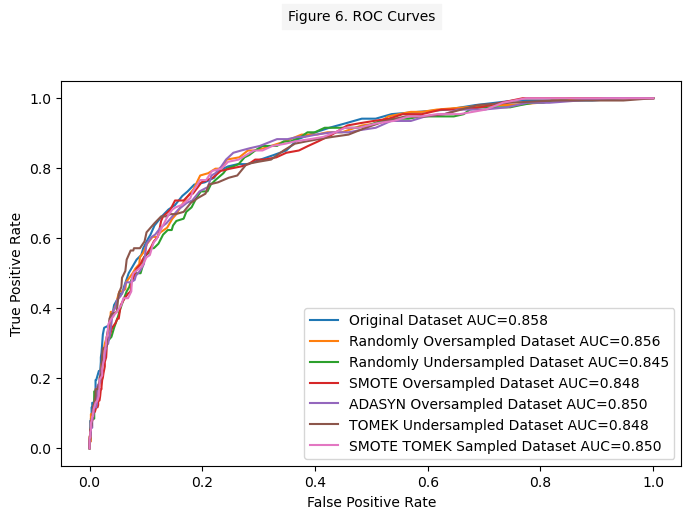

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.figtext(0.5,
            1.001,
            'Figure 6. ROC Curves',
            ha='center',
            fontsize=10,
            backgroundcolor='whitesmoke')
plot_roc(ax, X_train, y_train, X_test, y_test, 'Original Dataset')
plot_roc(ax, X_train_ros, y_train_ros, X_test, y_test,
         'Randomly Oversampled Dataset')
plot_roc(ax, X_train_rus, y_train_rus, X_test, y_test,
         'Randomly Undersampled Dataset')
plot_roc(ax, X_train_smote, y_train_smote, X_test, y_test,
         'SMOTE Oversampled Dataset')
plot_roc(ax, X_train_adasyn, y_train_adasyn, X_test, y_test,
         'ADASYN Oversampled Dataset')
plot_roc(ax, X_train_tomek, y_train_tomek, X_test, y_test,
         'TOMEK Undersampled Dataset')
plot_roc(ax, X_train_smotetomek, y_train_smotetomek, X_test, y_test,
         'SMOTE TOMEK Sampled Dataset');

# Hyperparameter Tuning
The Random Forest Classifier underwent grid search with various hyperparameters tested. The optimal hyperparameters were determined to be n_estimators=300, max_depth=15, and max_features=24. This resulted in a validation accuracy score of 86.34% and validation precision score of 69.30%. The top models can be found in `Table 6`.

Similar hyperparameters were applied to the holdout dataset, resulting in an accuracy score of 86.49% and a precision score of 70.78%.


In [28]:
sscaler = None
max_depth_range = list(range(1, 17)) + [None]
max_features_range = np.arange(1, X.shape[1] + 1)
pipe = Pipeline([('scaler', sscaler), ('clf', None)])
param_grid_rf = [
    {
        'clf': [RandomForestClassifier(n_estimators=300, random_state=1337)],
        'clf__max_depth': max_depth_range,
        'clf__max_features': max_features_range
    },
]

In [29]:
model_results_rf = []
for i in trange(10):
    X_trainval, X_test, y_trainval, y_test = train_test_split(X,
                                                              y,
                                                              test_size=0.2,
                                                              random_state=i)
    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid_rf,
        scoring={
            'accuracy': 'accuracy',
            'precision': make_scorer(precision_score, zero_division=0)
        },
        refit=False,
        n_jobs=-1,
    ).fit(X_trainval, y_trainval)
    model_results_rf.append(pd.DataFrame(grid_search.cv_results_))

100%|██████████| 10/10 [1:01:16<00:00, 367.70s/it]


In [76]:
cv_rf = pd.concat(model_results_rf)
cv_rf['clf'] = cv_rf.params.astype(str)
with pd.option_context("display.max_colwidth", None):
    display(
        cv_rf.groupby('clf')[[
            'mean_test_accuracy', 'mean_test_precision'
        ]].mean().reset_index().sort_values('mean_test_accuracy',
                                            ascending=False).head())
display(HTML("<center><i>Table 6. Top Models from GridSearchCV</i></center>"))

,clf,mean_test_accuracy,mean_test_precision
225,"{'clf': RandomForestClassifier(n_estimators=300, random_state=1337), 'clf__max_depth': 15, 'clf__max_features': 24}",0.8634,0.6930
226,"{'clf': RandomForestClassifier(n_estimators=300, random_state=1337), 'clf__max_depth': 15, 'clf__max_features': 25}",0.8633,0.6898
262,"{'clf': RandomForestClassifier(n_estimators=300, random_state=1337), 'clf__max_depth': 16, 'clf__max_features': 26}",0.8632,0.6905
569,"{'clf': RandomForestClassifier(n_estimators=300, random_state=1337), 'clf__max_depth': None, 'clf__max_features': 19}",0.8632,0.7008
221,"{'clf': RandomForestClassifier(n_estimators=300, random_state=1337), 'clf__max_depth': 15, 'clf__max_features': 20}",0.8632,0.6955


In [90]:
accuracy = []
precision = []
rf = RandomForestClassifier(random_state=1337,
                            n_estimators=300,
                            max_depth=15,
                            max_features=24,
                            n_jobs=-1)
for i in trange(10):
    X_trainval, X_test, y_trainval, y_test = train_test_split(X,
                                                              y,
                                                              test_size=0.2,
                                                              random_state=i)
    rf.fit(X_trainval, y_trainval)
    y_pred = rf.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred, zero_division=np.nan))

print(str(rf))
print(f'Mean Holdout Accuracy = {np.mean(accuracy):.4f}')
print(f'Mean Holdout Precision = {np.mean(precision):.4f}')

100%|██████████| 10/10 [00:03<00:00,  2.70it/s]

RandomForestClassifier(max_depth=15, max_features=24, n_estimators=300,
                       n_jobs=-1, random_state=1337)
Mean Holdout Accuracy = 0.8649
Mean Holdout Precision = 0.7078


# Statistical Test
The t-test results showed that the Gradient Boosting Classifier model by MicaelD and the Random Forest Classifier had similar accuracy scores but significantly different precision scores. The RandomForestClassifier outperformed the previous model in terms of precision.

In [21]:
accuracy_k = []
precision_k = []
kaggle = GradientBoostingClassifier(max_depth=4, random_state=0)
for i in trange(10):
    X_trainval, X_test, y_trainval, y_test = train_test_split(X,
                                                              y,
                                                              test_size=0.2,
                                                              random_state=i)
    kaggle.fit(X_trainval, y_trainval)
    y_pred = kaggle.predict(X_test)
    accuracy_k.append(accuracy_score(y_test, y_pred))
    precision_k.append(precision_score(y_test, y_pred))

print(str(kaggle))
print(f'Mean Holdout Accuracy = {np.mean(accuracy_k):.4f}')
print(f'Mean Holdout Precision = {np.mean(precision_k):.4f}')

100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

GradientBoostingClassifier(max_depth=4, random_state=0)
Mean Holdout Accuracy = 0.8634
Mean Holdout Precision = 0.6594


In [94]:
tt_acc = stats.ttest_ind(accuracy_k, accuracy)
print(tt_acc)
if tt_acc[1] < 0.05:
    print('There is a significant difference in accuracy')
else:
    print('There is no significant difference in accuracy')

TtestResult(statistic=-0.3028603953617253, pvalue=0.7654684487150938, df=18.0)
There is no significant difference in accuracy


In [95]:
tt_pre = stats.ttest_ind(precision_k, precision)
print(tt_pre)
if tt_pre[1] < 0.05:
    print('There is a significant difference in precision')
else:
    print('There is no significant difference in precision')

TtestResult(statistic=-2.2709987417881727, pvalue=0.035656524336448406, df=18.0)
There is a significant difference in precision


# SHAP
The Shapley global importance was visualized to assess the contribution of each feature to the overall prediction. "Like" emerged as the top feature, indicating that a higher rating of "like" for a partner increased the likelihood of a match. These results can be found in `Figure 7`.

Additionally, high ratings by the partner on three traits (attractive_o, shared_interests_o, funny_o) also predicted a match, suggesting that individuals are more likely to match if their partner rates them highly on attractiveness, perceived shared interests, or finds them funny.

Interestingly, the ratings for perceived similarity (shared_interests_o, shared_interests_partner) played a more significant role in predicting a match compared to the actual similarity in hobbies (interests_correlate). This suggests that a match is more likely to occur when individuals perceive their partner as similar to them, rather than when there is an objective measure of similarity.

In [32]:
rf.fit(X, y)
explainer = shap.Explainer(rf.predict, X)
shap_values = explainer(X)

PermutationExplainer explainer: 5026it [15:58,  5.19it/s]                          


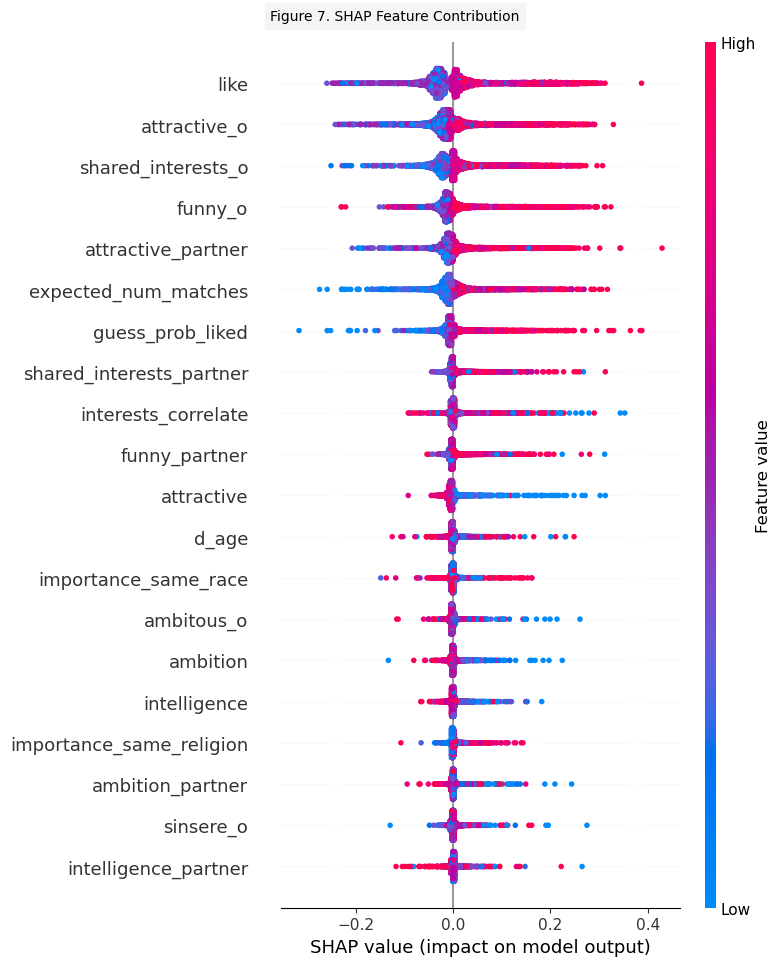

In [78]:
plt.figtext(0.5,
            1.001,
            'Figure 7. SHAP Feature Contribution',
            ha='center',
            fontsize=10,
            backgroundcolor='whitesmoke')
shap.summary_plot(
    shap_values,
    X,
)

# DICE

The DICE global importance, as seen in `Figure 8`, was plotted to identify the top contributing feature to the prediction. Interestingly, similar hobbies (interests_correlate) emerged as the top feature. This suggests that having common interests fosters compatibility and increases the likelihood of a successful match.

Age gap (d_age) was the 2nd top feature, followed by the partner’s ratings for particular traits (shared_interests_o, attractive_o, funny_o, ambition_o).


In [82]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X,
                                                          y,
                                                          test_size=0.2,
                                                          random_state=1337)
dice_model = Model(model=rf, backend='sklearn')

dice_data = Data(dataframe=X_trainval.join(y_trainval),
                 cat_features=X.select_dtypes('uint8').columns.tolist(),
                 continuous_features=X.select_dtypes(float).columns.tolist(),
                 outcome_name='match')

dice_exp = Dice(dice_data, dice_model, method='genetic')

In [35]:
global_feat_importance = dice_exp.global_feature_importance(
    X_trainval[y_trainval == 1].sample(100, random_state=1337))

100%|██████████| 100/100 [01:01<00:00,  1.61it/s]


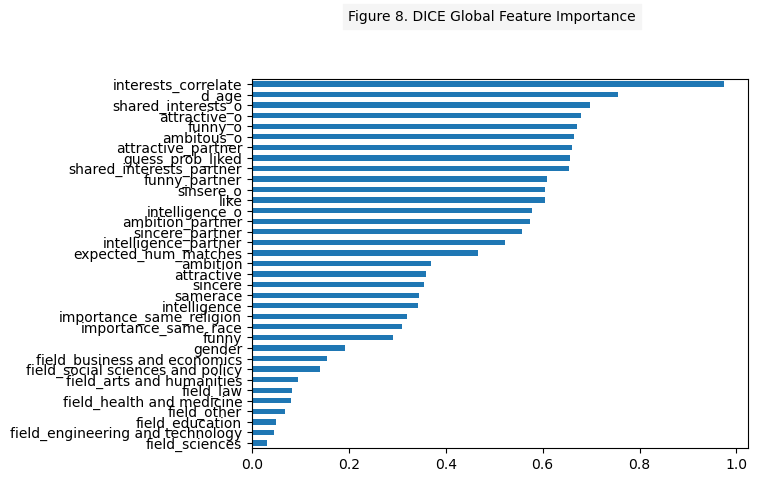

In [79]:
plt.figtext(0.5,
            1.001,
            'Figure 8. DICE Global Feature Importance',
            ha='center',
            fontsize=10,
            backgroundcolor='whitesmoke')
pd.Series(
    global_feat_importance.summary_importance).sort_values().plot(kind='barh');

## Counterfactual Analyses

Counterfactual analyses using DICE were conducted to explore the potential impact of varying specific features on changing a pair's outcome from "not a match" to a "match". Only features such as the partner's ratings (e.g., attractive_o, intelligence_o, etc.), interests_correlate, and expected_num_matches were adjusted, while keeping the ratings of the other partner constant to simulate the same individual within the pair.


### Counterfactual Scenario 1:
As shown in `Table 7`, a male participant received ratings of 4 for attractiveness, 6 for sincerity, and 7 for humor from their partner, and an interest correlation score of 0.26.  resulting in rejection. However, the outcome could have been a match if the participant's attractiveness rating had been increased to 8, sincerity to 7, and humor to 8, while the interest correlation score dropped to 0.23.


In [83]:
cfes1 = dice_exp.generate_counterfactuals(
    X_test.loc[[2303]],
    total_CFs=10,
    desired_class="opposite",
    features_to_vary=[
        "attractive_o",
        "sinsere_o",
        "intelligence_o",
        "funny_o",
        "ambitous_o",
        "shared_interests_o",
        "interests_correlate",
        "expected_num_matches",
    ],
)
cfes1.visualize_as_dataframe(show_only_changes=True)
display(HTML("<center><i>Table 7. Counterfactual Scenario 1</i></center>"))

100%|██████████| 1/1 [00:15<00:00, 15.89s/it]

Query instance (original outcome : 0)


,gender,d_age,samerace,importance_same_race,importance_same_religion,attractive_o,attractive,sinsere_o,sincere,intelligence,intelligence_o,funny_o,funny,ambitous_o,ambition,shared_interests_o,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_num_matches,like,guess_prob_liked,field_arts and humanities,field_business and economics,field_education,field_engineering and technology,field_health and medicine,field_law,field_other,field_sciences,field_social sciences and policy,match
0,1,5.0000,1,1.0000,1.0000,4.0000,6.0000,6.0000,7.0000,7.0000,7.0000,7.0000,7.0000,5.0000,5.0000,8.0000,6.0000,6.0000,6.0000,5.0000,4.0000,4.0000,0.2600,4.0000,7.0000,5.0000,0,0,0,0,1,0,0,0,0,0



Diverse Counterfactual set (new outcome: 1)


,gender,d_age,samerace,importance_same_race,importance_same_religion,attractive_o,attractive,sinsere_o,sincere,intelligence,intelligence_o,funny_o,funny,ambitous_o,ambition,shared_interests_o,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_num_matches,like,guess_prob_liked,field_arts and humanities,field_business and economics,field_education,field_engineering and technology,field_health and medicine,field_law,field_other,field_sciences,field_social sciences and policy,match
0,-,-,-,-,-,8.0,-,8.0,-,-,8.0,8.0,-,8.0,-,-,-,-,-,-,-,-,-0.2,6.0,-,-,-,-,-,-,-,-,-,-,-,1.0


### Counterfactual Scenario 2:
As shown in `Table 8`, a female participant received ratings of 1 for attractiveness, 7 for sincerity, 2 for humor, 3 for ambition, and 0.01 for shared interests from their partner. However, the participant could have had a match if they had been rated 8 for attractiveness, 8 for sincerity, 8 for humor, and 6 for shared interests. 

In both scenarios 1 and 2, the interplay between interest correlation and the various ratings was explored. When high ratings were given for attractiveness, humor, and sincerity, the result shifted to a match, irrespective of the level of interest correlation.


In [84]:
cfes2 = dice_exp.generate_counterfactuals(
    X_test.loc[[7883]],
    total_CFs=10,
    desired_class="opposite",
    features_to_vary=[
        "attractive_o",
        "sinsere_o",
        "intelligence_o",
        "funny_o",
        "ambitous_o",
        "shared_interests_o",
        "interests_correlate",
        "expected_num_matches",
    ],
)
cfes2.visualize_as_dataframe(show_only_changes=True)
display(HTML("<center><i>Table 8. Counterfactual Scenario 2</i></center>"))

100%|██████████| 1/1 [00:15<00:00, 15.77s/it]

Query instance (original outcome : 0)


,gender,d_age,samerace,importance_same_race,importance_same_religion,attractive_o,attractive,sinsere_o,sincere,intelligence,intelligence_o,funny_o,funny,ambitous_o,ambition,shared_interests_o,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_num_matches,like,guess_prob_liked,field_arts and humanities,field_business and economics,field_education,field_engineering and technology,field_health and medicine,field_law,field_other,field_sciences,field_social sciences and policy,match
0,0,1.0000,1,1.0000,1.0000,1.0000,3.0000,7.0000,9.0000,9.0000,8.0000,2.0000,9.0000,3.0000,7.0000,4.0000,6.0000,7.0000,7.0000,8.0000,8.0000,7.0000,0.0100,6.0000,7.0000,5.0000,0,0,0,1,0,0,0,0,0,0



Diverse Counterfactual set (new outcome: 1)


,gender,d_age,samerace,importance_same_race,importance_same_religion,attractive_o,attractive,sinsere_o,sincere,intelligence,intelligence_o,funny_o,funny,ambitous_o,ambition,shared_interests_o,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_num_matches,like,guess_prob_liked,field_arts and humanities,field_business and economics,field_education,field_engineering and technology,field_health and medicine,field_law,field_other,field_sciences,field_social sciences and policy,match
0,-,-,-,-,-,8.0,-,8.0,-,-,-,8.0,-,7.0,-,6.0,-,-,-,-,-,-,-0.06,3.0,-,-,-,-,-,-,-,-,-,-,-,1.0
0,-,-,-,-,-,7.0,-,8.0,-,-,7.0,7.0,-,7.0,-,7.0,-,-,-,-,-,-,0.18,-,-,-,-,-,-,-,-,-,-,-,-,1.0
0,-,-,-,-,-,7.0,-,-,-,-,7.0,8.0,-,7.0,-,7.0,-,-,-,-,-,-,0.25,3.0,-,-,-,-,-,-,-,-,-,-,-,1.0
0,-,-,-,-,-,7.0,-,-,-,-,9.0,7.0,-,7.0,-,7.0,-,-,-,-,-,-,0.35,7.0,-,-,-,-,-,-,-,-,-,-,-,1.0
0,-,-,-,-,-,7.0,-,-,-,-,-,7.0,-,8.0,-,7.0,-,-,-,-,-,-,0.62,4.0,-,-,-,-,-,-,-,-,-,-,-,1.0
0,-,-,-,-,-,8.0,-,8.0,-,-,-,8.0,-,6.0,-,7.0,-,-,-,-,-,-,0.49,3.0,-,-,-,-,-,-,-,-,-,-,-,1.0
0,-,-,-,-,-,6.0,-,-,-,-,7.0,7.0,-,5.0,-,7.0,-,-,-,-,-,-,0.73,2.0,-,-,-,-,-,-,-,-,-,-,-,1.0
0,-,-,-,-,-,7.0,-,10.0,-,-,7.0,7.0,-,7.0,-,5.0,-,-,-,-,-,-,0.34,4.0,-,-,-,-,-,-,-,-,-,-,-,1.0
